In [2]:
from ultralytics import YOLO
from PIL import Image
import numpy as np
import cv2
import supervision as sv
import easyocr
reader = easyocr.Reader(['en'], recognizer=False)

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


In [3]:
"""
YOLO-obb-small model trained on synthetic data on Google Colab runtime
"""
model = YOLO("../models/yolo-obb_s_50.pt")

In [33]:
def crop_license_plate(img):
    """
    Runs the YOLO model on the input image and crops the license plate

    Returns:
    - Image: the cropped license plate
    """
    results = model(img)

    detections = sv.Detections.from_ultralytics(results[0])
    xyxyxyxy = detections[0].data['xyxyxyxy'][0]

    point1, point2, point3, point4 = xyxyxyxy
    box_points = [point3, point2, point1, point4]

    # make blank image of size 520x110
    blank_image = np.zeros((110, 520, 3), np.uint8)
    blank_image[:] = (255, 255, 255)

    # warp
    matrix = cv2.getPerspectiveTransform(np.array(box_points, dtype=np.float32), np.array([[0, 0], [520, 0], [520, 110], [0, 110]], dtype=np.float32))
    warped = cv2.warpPerspective(cv2.imread(img), matrix, (520, 110))

    warped = cv2.cvtColor(warped, cv2.COLOR_BGR2RGB)
    warped = Image.fromarray(warped)
    return warped

In [44]:
def detect_text(img):
    """
    Detects text boxes in the input image

    Returns:
    - list: list of bounding boxes of the detected text
    """
    img = np.array(img)
    result = reader.detect(img, add_margin=0)[0][0]
    return result

def find_largest_text_area(bounding_boxes):
    """
    Finds the largest text area in the input image and returns the bounding box
    """
    max_width = 0
    box = None
    for box in bounding_boxes:
        width = box[1] - box[0]
        if width > max_width:
            max_width = width
            box = box
    return box

def extract_license_plate_text(img):
    """
    Extracts the text part of the license plate from the input image
    """
    result = detect_text(img)
    box = find_largest_text_area(result)

    img = np.array(img)

    cropped_img = img[box[2]:box[3], box[0]:box[1]]
    cropped_img = Image.fromarray(cropped_img)

    return cropped_img


result = reader.detect(cv2.imread("IMG_2080.jpg"), add_margin=0, slope_ths=0)[1][0][-1]
print(result)

[ WARN:0@2075.669] global loadsave.cpp:248 findDecoder imread_('IMG_2063.jpg'): can't open/read file: check file path/integrity


ValueError: Invalid input type. Supporting format = string(file path or url), bytes, numpy array


image 1/1 /home/mees/Desktop/UVA/Scriptie/License-Plate-Recognition-Thesis/ALPR/../test_notebooks/images/seat.webp: 384x640 773.7ms
Speed: 14.3ms preprocess, 773.7ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


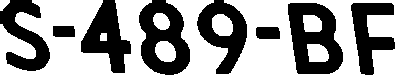

In [43]:
def thresholding(img):
    """
    Applies thresholding to the input image
    """
    img.save("temp.jpg")
    img = cv2.imread("temp.jpg", cv2.IMREAD_GRAYSCALE)

    
    kernel = np.ones((5,5),np.uint8)
    opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)

    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)

    _, im_gray_th_otsu = cv2.threshold(closing, 128, 192, cv2.THRESH_OTSU)

    _, im_gray_th = cv2.threshold(im_gray_th_otsu, 128, 255, cv2.THRESH_BINARY)

    return Image.fromarray(im_gray_th)

# crop_license_plate("IMG_2079.jpg").show()
# extract_license_plate_text(crop_license_plate("IMG_2079.jpg")).show()
thresholding(extract_license_plate_text(crop_license_plate("../test_notebooks/images/seat.webp")))